In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src")

In [2]:
from simulation import BaseSimulation
from individual_interaction_population import IndividualInteractionPopulation
from base_test_protocol import ContactTraceProtocol, QuarantineSymptomaticProtocol

In [3]:
import numpy as np
def prepare_pop(interactions_pp):
    n_agents = int(1E3)
    disease_length = 14
    quarantine_length = 14
    days_until_symptomatic = 7
    interaction_frequency_lambda =  interactions_pp

    population = IndividualInteractionPopulation(n_agents,
                                                disease_length,
                                                quarantine_length,
                                                days_until_symptomatic,
                                                interaction_frequency_lambda,
                                                interaction_infection_pct=0.05,
                                                initial_prevalence=0.005)
    
    # select only a single individual to be infected:
    infected_agent = np.random.choice(range(n_agents))
    for agent_idx in range(n_agents):
        if agent_idx == infected_agent:
            population.infection_status[agent_idx] = True
        else:
            population.infection_status[agent_idx] = False
    return population

In [4]:
def run_simulation(interactions_pp, time_horizon, test_protocol, verbose=False):
    pop = prepare_pop(interactions_pp)
  
    simulation = BaseSimulation(pop, test_protocol, test_frequency=1, test_latency=0)
    for day in range(time_horizon):
        simulation.step()
        if verbose:
            print("Done simulating day {}".format(day+1))
    
    return simulation

In [11]:
sim_results_notrace = {}
sim_results_trace = {}
interactions_per_person_values = [1,2,3,4,5,6,7,8,9]
time_horizon = 200

R0 = {}
for ipp in interactions_per_person_values:
    R0[ipp] = 0.05 * 7 * ipp
    print("R0 under symptomatic-only quarantine, under lambda = {}, is equal to {:.2f}".format(ipp, 0.05 * 7 * ipp))


for interactions_pp in interactions_per_person_values:
    sim_results_notrace[interactions_pp] = []
    sim_results_trace[interactions_pp] = []
    
    for x in range(25):
        notrace_test = QuarantineSymptomaticProtocol()
        sim_results_notrace[interactions_pp].append(run_simulation(interactions_pp, time_horizon, notrace_test))
        
        trace_test = ContactTraceProtocol()
        sim_results_trace[interactions_pp].append(run_simulation(interactions_pp, time_horizon, trace_test))
        
    print("Done iteration for interactions_pp value {}".format(interactions_pp))

R0 under symptomatic-only quarantine, under lambda = 1, is equal to 0.35
R0 under symptomatic-only quarantine, under lambda = 2, is equal to 0.70
R0 under symptomatic-only quarantine, under lambda = 3, is equal to 1.05
R0 under symptomatic-only quarantine, under lambda = 4, is equal to 1.40
R0 under symptomatic-only quarantine, under lambda = 5, is equal to 1.75
R0 under symptomatic-only quarantine, under lambda = 6, is equal to 2.10
R0 under symptomatic-only quarantine, under lambda = 7, is equal to 2.45
R0 under symptomatic-only quarantine, under lambda = 8, is equal to 2.80
R0 under symptomatic-only quarantine, under lambda = 9, is equal to 3.15
Done iteration for interactions_pp value 1
Done iteration for interactions_pp value 2
Done iteration for interactions_pp value 3
Done iteration for interactions_pp value 4
Done iteration for interactions_pp value 5
Done iteration for interactions_pp value 6
Done iteration for interactions_pp value 7
Done iteration for interactions_pp value 8

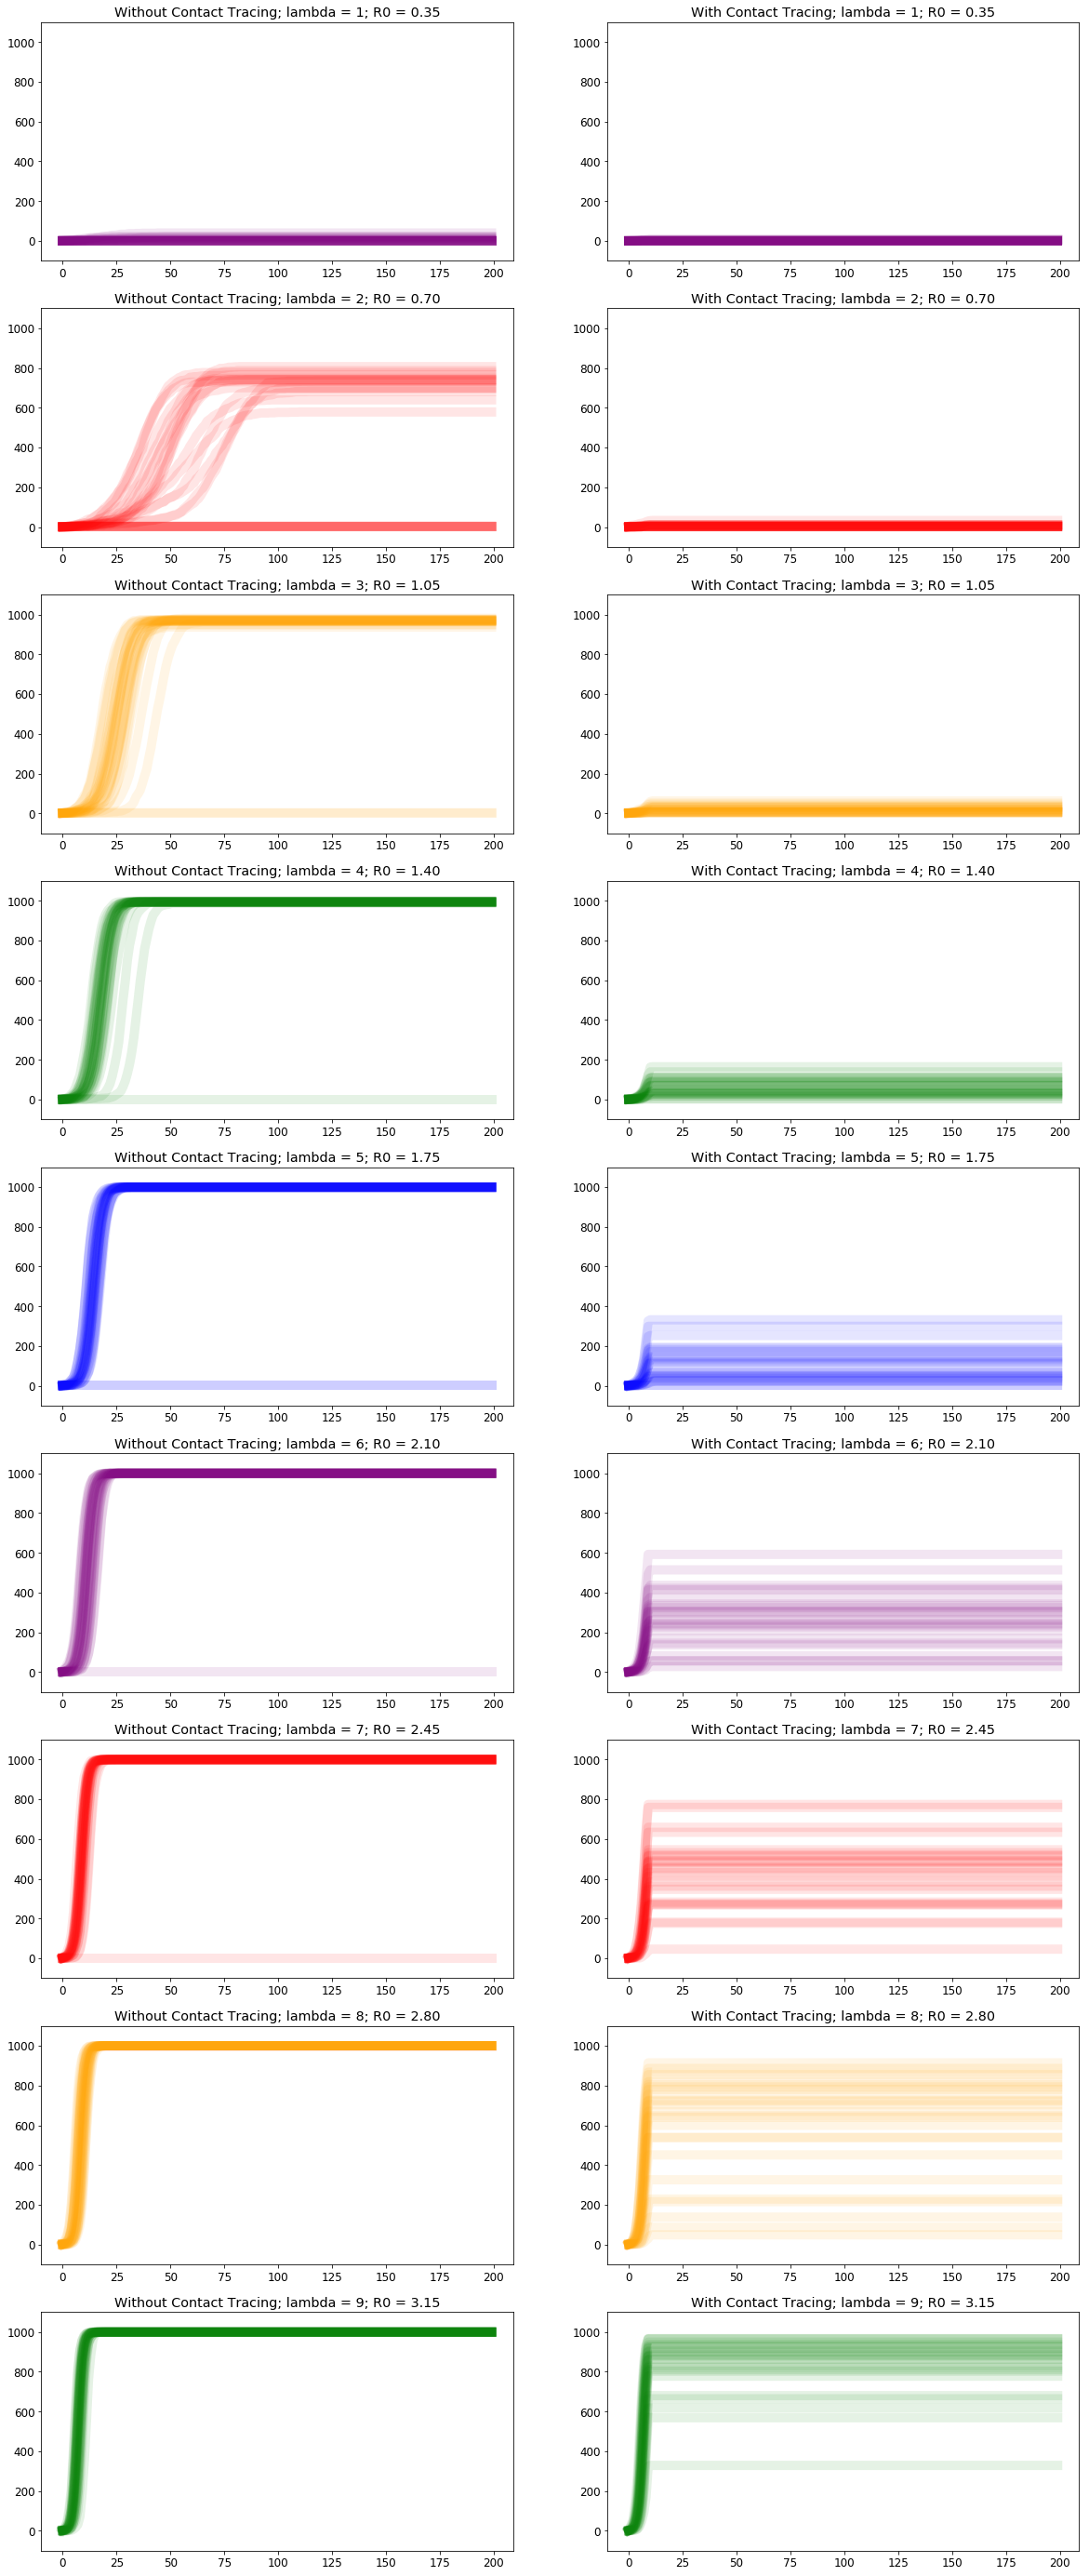

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

def add_plot(sim, days, color):
    infections = [sim.summary_population_data[day]['cumulative_num_infected'] for day in days]
    plt.plot(days, infections, linewidth=10.0, alpha=0.1, color=color)


plt.figure(figsize=(20,50))
interactions_per_person_values = [1,2,3,4,5,6,7,8,9]

colors={1:'purple', 2:'red', 3:'orange', 4:'green', 5:'blue'}



subplot_val = 1
nrows = 9
ncols = 2

days = list(range(time_horizon))

for interactions_pp in interactions_per_person_values:
    color = colors[(interactions_pp-1) % 5 + 1]
    plt.subplot(nrows, ncols, subplot_val)
    subplot_val += 1
    
    plt.title("Without Contact Tracing; lambda = {}; R0 = {:.2f}".format(interactions_pp, R0[interactions_pp]))
    plt.ylim(-100,1100)
    
    for sim in sim_results_notrace[interactions_pp]:
        add_plot(sim, days, color)
        
    plt.subplot(nrows, ncols, subplot_val)
    subplot_val += 1
    
    plt.title("With Contact Tracing; lambda = {}; R0 = {:.2f}".format(interactions_pp, R0[interactions_pp]))
    plt.ylim(-100,1100)
    
    for sim in sim_results_trace[interactions_pp]:
        add_plot(sim, days, color)
        
plt.show()